はじめに、Pythonのライブラリを起動する。

In [ ]:
# 必要なライブラリをインストール
!pip install -U statsmodels
!pip install japanize_matplotlib
!apt install aptitude
!aptitude install mecab libmecab-dev mecab-ipadic-utf8 git make curl xz-utils file -y
!pip install mecab-python3==0.7
!pip install neologdn
!pip install selenium
!apt-get update
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver/usr/bin

In [ ]:
# プログラム5.1
import csv
import glob
import os
import re
import time

import keras.initializers as initializers
import lightgbm as lgb
import MeCab
import neologdn
import numpy as np
import pandas as pd
from keras.layers import Conv1D, Dense, Dropout, Flatten, MaxPooling1D
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from mlxtend.regressor import StackingCVRegressor
from selenium import webdriver
from sklearn import ensemble, linear_model, svm, tree
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import TimeSeriesSplit
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
# Colabでファイルを読み込むために、Google Driveをマウント
from google.colab import drive
drive.mount('/content/drive')

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


Mounted at /content/drive


In [ ]:
#####
from matplotlib import pyplot as plt
from matplotlib.pylab import rcParams
rcParams["figure.figsize"] = 15, 6
import japanize_matplotlib

続いて、データを読み込む。Maehashi and Shintani (2020)の日本の月次マクロ経済変数219系列を利用する。

In [ ]:
# プログラム5.2
# データの読み込み
rawdata = pd.read_excel("/content/drive/My Drive/data_5.xlsx", sheet_name="MS(JJIE2020)", header=[0])
msdata = rawdata.iloc[:, 1:]
dlen = len(msdata)
dti = pd.date_range("1974-01-01", periods=dlen, freq="MS")

時系列データの交差検証は、以下のコードで実行できる。なお、訓練データと検証データの間の相関を下げるための間隔はコードの"gap"において2か月間と設定されている。また、コードの仕様により、交差検証は拡大ウィンドウ型により行われる。

In [ ]:
# プログラム5.3
PERIOD = 120  # 訓練データのサンプルサイズ（120か月）
H = 2  # 予測期間（2か月）
KF = 5  # K分割（K=5）
data_y = pd.DataFrame(msdata.x204)
data_x = pd.DataFrame(msdata)
vsample, hsample = len(data_x), len(data_x.columns)

ex_x = data_x[0 : 0 + PERIOD]
ex_y = data_y[0 + H : 0 + H + PERIOD]
# K分割交差検証
tscv = TimeSeriesSplit(n_splits=KF, gap=2)
for train_index, test_index in tscv.split(ex_x):
    train_xcv, test_xcv = ex_x.iloc[train_index, :], ex_x.iloc[test_index, :]
    train_ycv, test_ycv = ex_y.iloc[train_index], ex_y.iloc[test_index]
    print("TRAIN:", train_index, "TEST:", test_index)

TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17] TEST: [20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37] TEST: [40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57] TEST: [60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77] TEST: [80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33

In [ ]:
#####
# AR予測
predict_resultAR_list, sqe_resultAR_list = [], []
PERIOD = 120  # 訓練データのサンプルサイズ（120か月）
H = 12  # 予測期間（12か月）

predict_resultAR = np.zeros((vsample - H) - PERIOD)
sqe_resultAR = np.zeros((vsample - H) - PERIOD)
for i in range((vsample - H) - PERIOD):
    # 訓練データの指定
    train_x = data_y[i : i + PERIOD]
    train_y = data_y[H + i : H + i + PERIOD]
    # テストデータの指定
    test_x = data_y[i + PERIOD : i + PERIOD + 1]
    test_y = data_y[H + i + PERIOD : H + i + PERIOD + 1]
    # ARモデル
    model = linear_model.LinearRegression()
    model.fit(train_x, train_y)
    forecast = model.predict(test_x)
    predict_resultAR[i] = forecast
    sqe = ((test_y - forecast) ** 2).sum(axis=0)
    sqe_resultAR[i] = sqe

predict_resultAR_list.append(predict_resultAR)
sqe_resultAR_list.append(sqe_resultAR)

ラッソは、以下のコードで計算できる。コードの"N_LAMBDA"により調整パラメータのグリッド数を100としているほか、"KF"により交差検証は5分割としている。

In [ ]:
# プログラム5.4
# ラッソ
predict_result1_list, sqe_result1_list = [], []
PERIOD = 120  # 訓練データのサンプルサイズ（120か月）
H = 12  # 予測期間（12か月）
N_LAMBDA = 100  # 罰則項の調整パラメータのグリッド数
lasso_lambda = np.logspace(-2, 2, N_LAMBDA)
KF = 5  # K分割（K=5）

predict_result = np.zeros((vsample - H) - PERIOD)
sqe_result = np.zeros((vsample - H) - PERIOD)
for i in range((vsample - H) - PERIOD):
    # 訓練データの指定
    train_xx = data_x[i : i + PERIOD]
    train_y = data_y[H + i : H + i + PERIOD]
    scaler = StandardScaler()
    scaler.fit(train_xx)
    train_x = scaler.transform(train_xx)
    # テストデータの指定
    test_xx = data_x[i : i + PERIOD + 1]
    test_y = data_y[H + i + PERIOD : H + i + PERIOD + 1]
    scaler.fit(test_xx)
    test_xx_std = scaler.transform(test_xx)
    test_x = test_xx_std[PERIOD : PERIOD + 1]
    # ラッソ推定
    cvbox = np.zeros([KF, N_LAMBDA])
    for hpi in range(N_LAMBDA):
        tscv = TimeSeriesSplit(n_splits=KF)
        counter = 1
        for train_index, test_index in tscv.split(train_x):
            train_xcv, test_xcv = train_x[train_index, :], train_x[test_index, :]
            train_ycv, test_ycv = train_y.iloc[train_index], train_y.iloc[test_index]
            lasso_cv = linear_model.Lasso(alpha=lasso_lambda[hpi], fit_intercept=True)
            model_cv = lasso_cv.fit(train_xcv, train_ycv)
            resid_cv = (model_cv.predict(test_xcv) - np.ravel(test_ycv.values)) ** 2
            cvbox[counter - 1, hpi] = resid_cv.sum()
            counter = counter + 1
    op_hpi = pd.DataFrame(np.average(cvbox, axis=0)).idxmin()
    op_lambda = lasso_lambda[op_hpi]
    lasso_best = linear_model.Lasso(alpha=op_lambda, fit_intercept=True)
    model_best = lasso_best.fit(train_x, train_y)
    forecast = model_best.predict(test_x)
    predict_result[i] = forecast
    sqe = ((test_y - forecast) ** 2).sum(axis=0)
    sqe_result[i] = sqe

predict_result1_list.append(predict_result)
sqe_result1_list.append(sqe_result)

リッジ回帰は、以下のコードで計算できる。同様に、"N_LAMBDA"で調整パラメータのグリッド数、"KF"で交差検証の分割数を設定している。

In [ ]:
# プログラム5.5
# リッジ回帰
predict_result2_list, sqe_result2_list = [], []
PERIOD = 120  # 訓練データのサンプルサイズ（120か月）
H = 12  # 予測期間（12か月）
N_LAMBDA = 100  # 罰則項の調整パラメータのグリッド数
ridge_lambda = np.logspace(-2, 2, N_LAMBDA)
KF = 5  # K分割（K=5）

predict_result = np.zeros((vsample - H) - PERIOD)
sqe_result = np.zeros((vsample - H) - PERIOD)
for i in range((vsample - H) - PERIOD):
    # 訓練データの指定
    train_xx = data_x[i : i + PERIOD]
    train_y = data_y[H + i : H + i + PERIOD]
    scaler = StandardScaler()
    scaler.fit(train_xx)
    train_x = scaler.transform(train_xx)
    # テストデータの指定
    test_xx = data_x[i : i + PERIOD + 1]
    test_y = data_y[H + i + PERIOD : H + i + PERIOD + 1]
    scaler.fit(test_xx)
    test_xx_std = scaler.transform(test_xx)
    test_x = test_xx_std[PERIOD : PERIOD + 1]
    # リッジ回帰推定
    cvbox = np.zeros([KF, N_LAMBDA])
    for hpi in range(N_LAMBDA):
        tscv = TimeSeriesSplit(n_splits=KF)
        counter = 1
        for train_index, test_index in tscv.split(train_x):
            train_xcv, test_xcv = train_x[train_index, :], train_x[test_index, :]
            train_ycv, test_ycv = train_y.iloc[train_index], train_y.iloc[test_index]
            ridge_cv = linear_model.Ridge(alpha=ridge_lambda[hpi], fit_intercept=True)
            model_cv = ridge_cv.fit(train_xcv, train_ycv)
            resid_cv = (model_cv.predict(test_xcv) - np.ravel(test_ycv.values)) ** 2
            cvbox[counter - 1, hpi] = resid_cv.sum()
            counter = counter + 1
    op_hpi = pd.DataFrame(np.average(cvbox, axis=0)).idxmin()
    op_lambda = ridge_lambda[op_hpi]
    ridge_best = linear_model.Ridge(alpha=op_lambda, fit_intercept=True)
    model_best = ridge_best.fit(train_x, train_y)
    forecast = model_best.predict(test_x)
    predict_result[i] = forecast
    sqe = ((test_y - forecast) ** 2).sum(axis=0)
    sqe_result[i] = sqe

predict_result2_list.append(predict_result)
sqe_result2_list.append(sqe_result)

エラスティックネットは、以下のコードで計算できる。"N_LAMBDA"は罰則項の調整パラメータのグリッド数、"N_OMEGA"は$L_{1}$ノルムと$L_{2}$ノルムの重みの調整パラメータのグリッド数を設定している。

In [ ]:
# 5-6
# エラスティックネット
predict_result3_list, sqe_result3_list = [], []
PERIOD = 120  # 訓練データのサンプルサイズ（120か月）
H = 12  # 予測期間（12か月）
N_LAMBDA = 10  # 罰則項の調整パラメータのグリッド数
en_lambda = np.logspace(-2, 2, N_LAMBDA)
N_OMEGA = 11  # L1ノルムとL2ノルムの重みの調整パラメータのグリッド数
en_omega = np.linspace(0, 1, N_OMEGA)
KF = 5  # K分割（K=5）

predict_result = np.zeros((vsample - H) - PERIOD)
sqe_result = np.zeros((vsample - H) - PERIOD)
for i in range((vsample - H) - PERIOD):
    # 訓練データの指定
    train_xx = data_x[i : i + PERIOD]
    train_y = data_y[H + i : H + i + PERIOD]
    scaler = StandardScaler()
    scaler.fit(train_xx)
    train_x = scaler.transform(train_xx)
    # テストデータの指定
    test_xx = data_x[i : i + PERIOD + 1]
    test_y = data_y[H + i + PERIOD : H + i + PERIOD + 1]
    scaler.fit(test_xx)
    test_xx_std = scaler.transform(test_xx)
    test_x = test_xx_std[PERIOD : PERIOD + 1]
    # エラスティックネット推定
    cvbox = np.zeros([KF, N_LAMBDA * len(en_omega)])
    for hpi in range(N_LAMBDA * len(en_omega)):
        tscv = TimeSeriesSplit(n_splits=KF)
        counter = 1
        for train_index, test_index in tscv.split(train_x):
            train_xcv, test_xcv = train_x[train_index, :], train_x[test_index, :]
            train_ycv, test_ycv = train_y.iloc[train_index], train_y.iloc[test_index]
            en_cv = linear_model.ElasticNet(
                alpha=en_lambda[hpi // len(en_omega)],
                l1_ratio=en_omega[hpi % len(en_omega)],
                fit_intercept=True,
            )
            model_cv = en_cv.fit(train_xcv, train_ycv)
            resid_cv = (model_cv.predict(test_xcv) - np.ravel(test_ycv.values)) ** 2
            cvbox[counter - 1, hpi] = resid_cv.sum()
            counter = counter + 1
    op_hpi = int((pd.DataFrame(np.average(cvbox, axis=0)).idxmin()).values)
    op_alpha = en_lambda[op_hpi // len(en_omega)]
    op_ratio = en_omega[op_hpi % len(en_omega)]
    en_best = linear_model.ElasticNet(
        alpha=op_alpha, l1_ratio=op_ratio, fit_intercept=True
    )
    model_best = en_best.fit(train_x, train_y)
    forecast = model_best.predict(test_x)
    predict_result[i] = forecast
    sqe = ((test_y - forecast) ** 2).sum(axis=0)
    sqe_result[i] = sqe

predict_result3_list.append(predict_result)
sqe_result3_list.append(sqe_result)

以上、正則化最小2乗推定量の結果をまとめると、図5.1を作成できる。

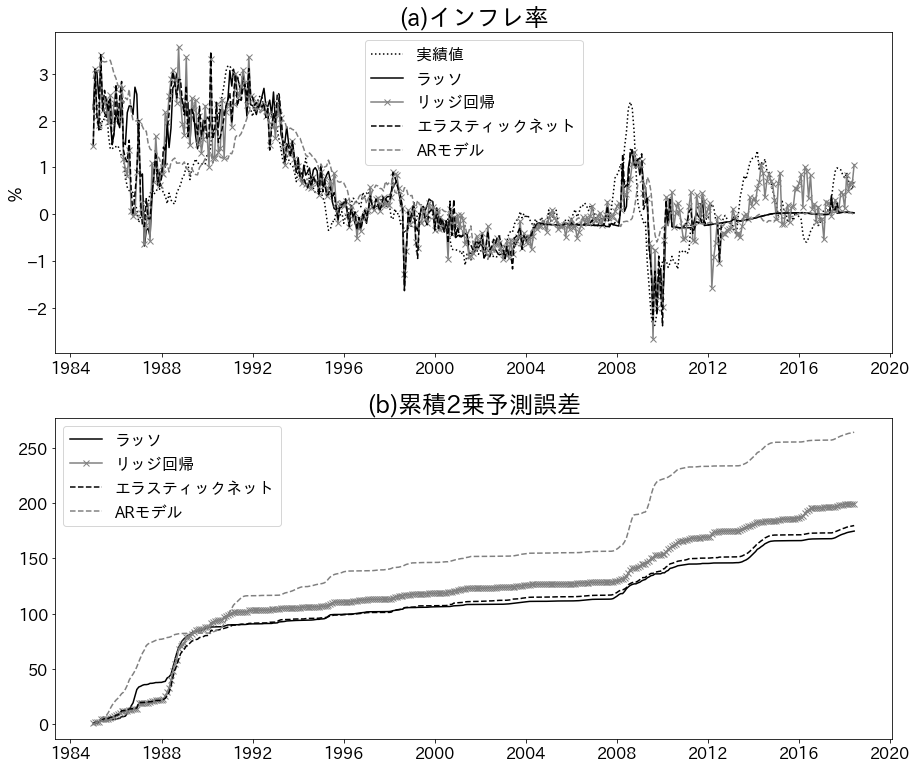

In [ ]:
#####
# グラフを描画
fig = plt.figure(figsize=(15, 13))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
ax1.set_title("(a)インフレ率", fontsize=24)
ax1.plot(dti[H + PERIOD :], np.ravel(msdata.x204[H + PERIOD :]), label="実績値", color="black", linestyle="dotted")
ax1.plot(dti[H + PERIOD :], np.ravel(predict_result1_list), label="ラッソ", color="black")
ax1.plot(dti[H + PERIOD :], np.ravel(predict_result2_list), label="リッジ回帰", color="grey", marker="x")
ax1.plot(dti[H + PERIOD :], np.ravel(predict_result3_list), label="エラスティックネット", color="black", linestyle="dashed")
ax1.plot(dti[H + PERIOD :], np.ravel(predict_resultAR_list), label="ARモデル", color="grey", linestyle="dashed")
ax1.legend(loc="upper center", fontsize=16)
ax1.tick_params(labelsize=16)
ax1.set_ylabel("％", fontsize=16)
ax2.set_title("(b)累積2乗予測誤差", fontsize=24)
ax2.plot(dti[H + PERIOD :], np.ravel(sqe_result1_list).cumsum(), label="ラッソ", color="black")
ax2.plot(dti[H + PERIOD :], np.ravel(sqe_result2_list).cumsum(), label="リッジ回帰", color="grey", marker="x")
ax2.plot(dti[H + PERIOD :], np.ravel(sqe_result3_list).cumsum(), label="エラスティックネット", color="black", linestyle="dashed")
ax2.plot(dti[H + PERIOD :], np.ravel(sqe_resultAR_list).cumsum(), label="ARモデル", color="grey", linestyle="dashed")
ax2.legend(loc="upper left", fontsize=16)
ax2.tick_params(labelsize=16)

線形SVRは、以下のコードで計算できる。

In [ ]:
# プログラム5.7
# SVR（線形）
predict_result4_list, sqe_result4_list = [], []
PERIOD = 120  # 訓練データのサンプルサイズ（120か月）
H = 12  # 予測期間（12か月）
N_C = 16  # 調整パラメータCのグリッド数
svr_c = 2 ** np.linspace(-5, 10, N_C)
N_EPSILON = 11 # 調整パラメータepsilonのグリッド数
svr_epsilon = 2 ** np.linspace(-10, 0, N_EPSILON)
KF = 5  # K分割（K=5）

predict_result = np.zeros((vsample - H) - PERIOD)
sqe_result = np.zeros((vsample - H) - PERIOD)
for i in range((vsample - H) - PERIOD):
    # 訓練データの指定
    train_xx = data_x[i : i + PERIOD]
    train_y = data_y[H + i : H + i + PERIOD]
    scaler = StandardScaler()
    scaler.fit(train_xx)
    train_x = scaler.transform(train_xx)
    # テストデータの指定
    test_xx = data_x[i : i + PERIOD + 1]
    test_y = data_y[H + i + PERIOD : H + i + PERIOD + 1]
    scaler.fit(test_xx)
    test_xx_std = scaler.transform(test_xx)
    test_x = test_xx_std[PERIOD : PERIOD + 1]
    # SVR推定
    cvbox = np.zeros([KF, len(svr_c) * len(svr_epsilon)])
    for hpi in range(len(svr_c) * len(svr_epsilon)):
        tscv = TimeSeriesSplit(n_splits=KF, gap=4)
        counter = 1
        for train_index, test_index in tscv.split(train_x):
            train_xcv, test_xcv = train_x[train_index, :], train_x[test_index, :]
            train_ycv, test_ycv = train_y.iloc[train_index], train_y.iloc[test_index]
            svr_cv = svm.SVR(
                kernel="linear",
                C=svr_c[hpi // len(svr_epsilon)],
                epsilon=svr_epsilon[hpi % len(svr_epsilon)],
            )
            model_cv = svr_cv.fit(train_xcv, train_ycv)
            resid_cv = (model_cv.predict(test_xcv) - np.ravel(test_ycv.values)) ** 2
            cvbox[counter - 1, hpi] = resid_cv.sum()
            counter = counter + 1
    op_hpi = int((pd.DataFrame(np.average(cvbox, axis=0)).idxmin()).values)
    op_c = svr_c[op_hpi // len(svr_epsilon)]
    op_epsilon = svr_epsilon[op_hpi % len(svr_epsilon)]
    svr_best = svm.SVR(kernel="linear", C=op_c, epsilon=op_epsilon)
    model_best = svr_best.fit(train_x, train_y)
    forecast = model_best.predict(test_x)
    predict_result[i] = forecast
    sqe = (test_y - forecast) ** 2
    sqe_result[i] = sqe.sum(axis=0)
    
predict_result4_list.append(predict_result)
sqe_result4_list.append(sqe_result)

非線形SVRは、以下のコードで計算できる。

In [ ]:
# プログラム5.8
# SVR（非線形）
predict_result4n_list, sqe_result4n_list = [], []
PERIOD = 120  # 訓練データのサンプルサイズ（120か月）
H = 12  # 予測期間（12か月）
N_C = 16  # 調整パラメータCのグリッド数
svr_c = 2 ** np.linspace(-5, 10, N_C)
N_EPSILON = 11 # 調整パラメータepsilonのグリッド数
svr_epsilon = 2 ** np.linspace(-10, 0, N_EPSILON)
N_GAMMA = 31 # 調整パラメータgammaのグリッド数
svr_gamma = 2 ** np.linspace(-20, 10, N_GAMMA)
KF = 5  # K分割（K=5）

predict_result = np.zeros((vsample - H) - PERIOD)
sqe_result = np.zeros((vsample - H) - PERIOD)
for i in range((vsample - H) - PERIOD):
    # 訓練データの指定
    train_xx = data_x[i : i + PERIOD]
    train_y = data_y[H + i : H + i + PERIOD]
    scaler = StandardScaler()
    scaler.fit(train_xx)
    train_x = scaler.transform(train_xx)
    # テストデータの指定
    test_xx = data_x[i : i + PERIOD + 1]
    test_y = data_y[H + i + PERIOD : H + i + PERIOD + 1]
    scaler.fit(test_xx)
    test_xx_std = scaler.transform(test_xx)
    test_x = test_xx_std[PERIOD : PERIOD + 1]
    # 調整パラメータgammaをグラム行列の分散が最大となるように選択
    np_train_x = np.array(train_x)
    variance_of_gram_matrix = list()
    for svr_gamma_temp in svr_gamma:
        gram_matrix = np.exp(
            -svr_gamma_temp * ((np_train_x[:, np.newaxis] - np_train_x) ** 2).sum(axis=2)
        )
        variance_of_gram_matrix.append(gram_matrix.var(ddof=1))
    op_svr_gamma = svr_gamma[
        np.where(variance_of_gram_matrix == np.max(variance_of_gram_matrix))[0][0]
    ]
    # 調整パラメータCについては、被説明変数の平均＋標準偏差×3となるように選択
    op_svr_c = abs(np.average(train_y) + np.std(train_y) * 3)
    # SVR推定
    cvbox = np.zeros([KF, len(svr_epsilon)])
    for hpi in range(0, len(svr_epsilon), 1):
        tscv = TimeSeriesSplit(n_splits=KF)
        counter = 1
        for train_index, test_index in tscv.split(train_x):
            train_xcv, test_xcv = train_x[train_index, :], train_x[test_index, :]
            train_ycv, test_ycv = train_y.iloc[train_index], train_y.iloc[test_index]
            svr_cv = svm.SVR(kernel="rbf", gamma=op_svr_gamma, C=op_svr_c, epsilon=svr_epsilon[hpi])
            model_cv = svr_cv.fit(train_xcv, train_ycv)
            resid_cv = (model_cv.predict(test_xcv) - np.ravel(test_ycv.values)) ** 2
            cvbox[counter - 1, hpi] = resid_cv.sum()
            counter = counter + 1
    op_hpi = int((pd.DataFrame(np.average(cvbox, axis=0)).idxmin()).values)
    op_epsilon = svr_epsilon[op_hpi]
    cvbox = np.zeros([KF, len(svr_c)])
    for hpi in range(0, len(svr_c), 1):
        tscv = TimeSeriesSplit(n_splits=KF)
        counter = 1
        for train_index, test_index in tscv.split(train_x):
            train_xcv, test_xcv = train_x[train_index, :], train_x[test_index, :]
            train_ycv, test_ycv = train_y.iloc[train_index], train_y.iloc[test_index]
            svr_cv = svm.SVR(kernel="rbf", gamma=op_svr_gamma, C=svr_c[hpi], epsilon=op_epsilon)
            model_cv = svr_cv.fit(train_xcv, train_ycv)
            resid_cv = (model_cv.predict(test_xcv) - np.ravel(test_ycv.values)) ** 2
            cvbox[counter - 1, hpi] = resid_cv.sum()
            counter = counter + 1
    op_hpi = int((pd.DataFrame(np.average(cvbox, axis=0)).idxmin()).values)
    op_c = svr_c[op_hpi]
    cvbox = np.zeros([KF, len(svr_gamma)])
    for hpi in range(0, len(svr_gamma), 1):
        tscv = TimeSeriesSplit(n_splits=KF)
        counter = 1
        for train_index, test_index in tscv.split(train_x):
            train_xcv, test_xcv = train_x[train_index, :], train_x[test_index, :]
            train_ycv, test_ycv = train_y.iloc[train_index], train_y.iloc[test_index]
            svr_cv = svm.SVR(kernel="rbf", gamma=svr_gamma[hpi], C=op_c, epsilon=op_epsilon)
            model_cv = svr_cv.fit(train_xcv, train_ycv)
            resid_cv = (model_cv.predict(test_xcv) - np.ravel(test_ycv.values)) ** 2
            cvbox[counter - 1, hpi] = resid_cv.sum()
            counter = counter + 1
    op_hpi = int((pd.DataFrame(np.average(cvbox, axis=0)).idxmin()).values)
    op_gamma = svr_gamma[op_hpi]
    svr_best = svm.SVR(kernel="rbf", gamma=op_gamma, C=op_c, epsilon=op_epsilon)
    model_best = svr_best.fit(train_x, train_y)
    forecast = model_best.predict(test_x)
    predict_result[i] = forecast
    sqe = ((test_y - forecast) ** 2).sum(axis=0)
    sqe_result[i] = sqe

predict_result4n_list.append(predict_result)
sqe_result4n_list.append(sqe_result)

以上、SVRの結果をまとめると、図5.2を作成できる。

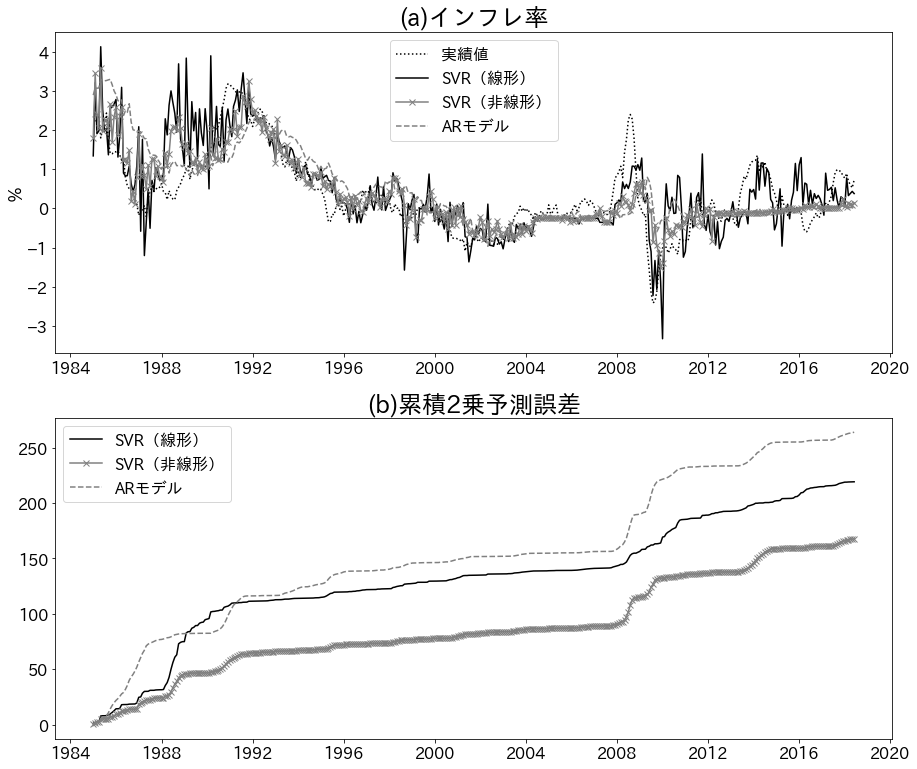

In [ ]:
#####
# グラフを描画
fig = plt.figure(figsize=(15, 13))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
ax1.set_title("(a)インフレ率", fontsize=24)
ax1.plot(dti[H + PERIOD :], np.ravel(msdata.x204[H + PERIOD :]), label="実績値", color="black", linestyle="dotted")
ax1.plot(dti[H + PERIOD :], np.ravel(predict_result4_list), label="SVR（線形）", color="black")
ax1.plot(dti[H + PERIOD :], np.ravel(predict_result4n_list), label="SVR（非線形）", color="grey", marker="x")
ax1.plot(dti[H + PERIOD :], np.ravel(predict_resultAR_list), label="ARモデル", color='grey', linestyle="dashed")
ax1.legend(loc="upper center", fontsize=16)
ax1.tick_params(labelsize=16)
ax1.set_ylabel("％", fontsize=16)
ax2.set_title("(b)累積2乗予測誤差", fontsize=24)
ax2.plot(dti[H + PERIOD :], np.ravel(sqe_result4_list).cumsum(), label="SVR（線形）", color="black")
ax2.plot(dti[H + PERIOD :], np.ravel(sqe_result4n_list).cumsum(), label="SVR（非線形）", color="grey", marker="x")
ax2.plot(dti[H + PERIOD :], np.ravel(sqe_resultAR_list).cumsum(), label="ARモデル", color='grey', linestyle="dashed")
ax2.legend(loc="upper left", fontsize=16)
ax2.tick_params(labelsize=16)

バギングは、以下のコードで計算できる。コードの"n_estimators"において、作成するバギングのブートストラップ標本の数を10と設定している。

In [ ]:
# プログラム5.9
# バギング
predict_result5_list, sqe_result5_list = [], []
PERIOD = 120  # 訓練データのサンプルサイズ（120か月）
H = 12  # 予測期間（12か月）

predict_result = np.zeros((vsample - H) - PERIOD)
sqe_result = np.zeros((vsample - H) - PERIOD)
for i in range((vsample - H) - PERIOD):
    # 訓練データの指定
    train_xx = data_x[i : i + PERIOD]
    train_y = data_y[H + i : H + i + PERIOD]
    scaler = StandardScaler()
    scaler.fit(train_xx)
    train_x = scaler.transform(train_xx)
    # テストデータの指定
    test_xx = data_x[i : i + PERIOD + 1]
    test_y = data_y[H + i + PERIOD : H + i + PERIOD + 1]
    scaler.fit(test_xx)
    test_xx_std = scaler.transform(test_xx)
    test_x = test_xx_std[PERIOD : PERIOD + 1]
    # バギング推定
    model = ensemble.BaggingRegressor(
        base_estimator=tree.DecisionTreeRegressor(), n_estimators=10
    )
    model.fit(train_x, train_y)
    forecast = model.predict(test_x)
    predict_result[i] = forecast
    sqe = ((test_y - forecast) ** 2).sum(axis=0)
    sqe_result[i] = sqe

predict_result5_list.append(predict_result)
sqe_result5_list.append(sqe_result)

ランダムフォレストは、以下のコードで計算できる。コードの"max_samples"において、部分集合の予測変数の数を全予測変数の半分とするように設定している。

In [ ]:
# プログラム5.10
# ランダムフォレスト
predict_result6_list, sqe_result6_list = [], []
PERIOD = 120  # 訓練データのサンプルサイズ（120か月）
H = 12  # 予測期間（12か月）

predict_result = np.zeros((vsample - H) - PERIOD)
sqe_result = np.zeros((vsample - H) - PERIOD)
for i in range((vsample - H) - PERIOD):
    # 訓練データの指定
    train_xx = data_x[i : i + PERIOD]
    train_y = data_y[H + i : H + i + PERIOD]
    scaler = StandardScaler()
    scaler.fit(train_xx)
    train_x = scaler.transform(train_xx)
    # テストデータの指定
    test_xx = data_x[i : i + PERIOD + 1]
    test_y = data_y[H + i + PERIOD : H + i + PERIOD + 1]
    scaler.fit(test_xx)
    test_xx_std = scaler.transform(test_xx)
    test_x = test_xx_std[PERIOD : PERIOD + 1]
    # ランダムフォレスト推定
    model = ensemble.RandomForestRegressor(max_samples=0.5)
    model.fit(train_x, train_y)
    forecast = model.predict(test_x)
    predict_result[i] = forecast
    sqe = ((test_y - forecast) ** 2).sum(axis=0)
    sqe_result[i] = sqe

predict_result6_list.append(predict_result)
sqe_result6_list.append(sqe_result)

lightGBMを用いたブースティングは、以下のコードで計算できる。コードの"learning_rate"において、学習率を0.1と設定している。

In [ ]:
# プログラム5.11
# ブースティング（lightGBM）
predict_result7_list, sqe_result7_list = [], []
PERIOD = 120  # 訓練データのサンプルサイズ（120か月）
H = 12  # 予測期間（12か月）

predict_result = np.zeros((vsample - H) - PERIOD)
sqe_result = np.zeros((vsample - H) - PERIOD)
for i in range((vsample - H) - PERIOD):
    # 訓練データの指定
    train_xx = data_x[i : i + PERIOD]
    train_y = data_y[H + i : H + i + PERIOD]
    scaler = StandardScaler()
    scaler.fit(train_xx)
    train_x = scaler.transform(train_xx)
    # テストデータの指定
    test_xx = data_x[i : i + PERIOD + 1]
    test_y = data_y[H + i + PERIOD : H + i + PERIOD + 1]
    scaler.fit(test_xx)
    test_xx_std = scaler.transform(test_xx)
    test_x = test_xx_std[PERIOD : PERIOD + 1]
    # ブースティング推定
    model = lgb.LGBMRegressor(learning_rate=0.1)
    model.fit(train_x, train_y)
    forecast = model.predict(test_x)
    predict_result[i] = forecast
    sqe = (test_y - forecast) ** 2
    sqe_result[i] = sqe.sum(axis=0)

predict_result7_list.append(predict_result)
sqe_result7_list.append(sqe_result)

スタッキングは、以下のコードで計算できる。事前に1段目の関数と2段目の関数を指定している。また、"StackingCVRegressor"の仕様により、交差検証は5分割となっている。

In [ ]:
# プログラム5.12
# スタッキング
predict_result8_list, sqe_result8_list = [], []
PERIOD = 120  # 訓練データのサンプルサイズ（120か月）
H = 12  # 予測期間（12か月）
# 1段目の関数
reg1 = linear_model.Lasso()
reg2 = linear_model.ElasticNet()
reg3 = svm.SVR()
reg4 = ensemble.BaggingRegressor()
reg5 = ensemble.RandomForestRegressor()
reg6 = lgb.LGBMRegressor()
# 2段目の関数
meta_model = linear_model.Ridge()

predict_result = np.zeros((vsample - H) - PERIOD)
sqe_result = np.zeros((vsample - H) - PERIOD)
for i in range((vsample - H) - PERIOD):
    # 訓練データの指定
    train_xx = data_x[i : i + PERIOD]
    train_y = data_y[H + i : H + i + PERIOD]
    scaler = StandardScaler()
    scaler.fit(train_xx)
    train_x = scaler.transform(train_xx)
    # テストデータの指定
    test_xx = data_x[i : i + PERIOD + 1]
    test_y = data_y[H + i + PERIOD : H + i + PERIOD + 1]
    scaler.fit(test_xx)
    test_xx_std = scaler.transform(test_xx)
    test_x = test_xx_std[PERIOD : PERIOD + 1]
    # スタッキング推定
    model = StackingCVRegressor(
        regressors=[reg1, reg2, reg3, reg4, reg5, reg6], meta_regressor=meta_model
    )
    model.fit(train_x, train_y)
    forecast = model.predict(test_x)
    predict_result[i] = forecast
    sqe = (test_y - forecast) ** 2
    sqe_result[i] = sqe.sum(axis=0)

predict_result8_list.append(predict_result)
sqe_result8_list.append(sqe_result)

以上、回帰木とアンサンブル学習の結果をまとめると、図5.6を作成できる。

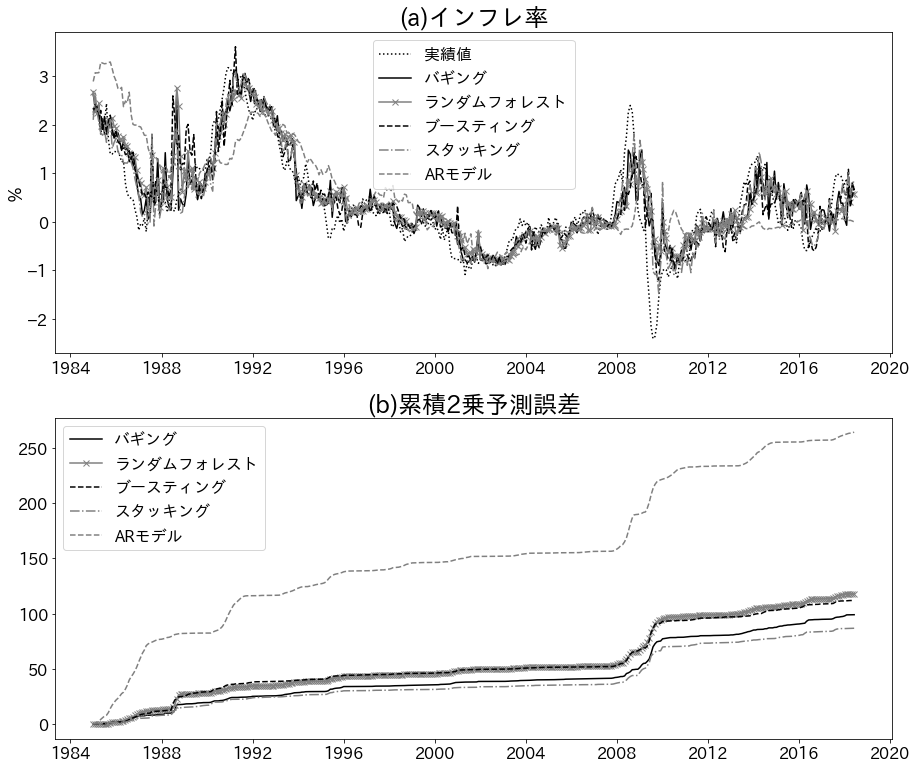

In [ ]:
#####
# グラフを描画
fig = plt.figure(figsize=(15, 13))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
ax1.set_title("(a)インフレ率", fontsize=24)
ax1.plot(dti[H + PERIOD :], np.ravel(msdata.x204[H + PERIOD :]), label="実績値", color="black", linestyle="dotted")
ax1.plot(dti[H + PERIOD :], np.ravel(predict_result5_list), label="バギング", color="black")
ax1.plot(dti[H + PERIOD :], np.ravel(predict_result6_list), label="ランダムフォレスト", color="grey", marker="x")
ax1.plot(dti[H + PERIOD :], np.ravel(predict_result7_list), label="ブースティング", color='black', linestyle="dashed")
ax1.plot(dti[H + PERIOD :], np.ravel(predict_result8_list), label="スタッキング", color='grey', linestyle="dashdot")
ax1.plot(dti[H + PERIOD :], np.ravel(predict_resultAR_list), label="ARモデル", color='grey', linestyle="dashed")
ax1.legend(loc="upper center", fontsize=16)
ax1.tick_params(labelsize=16)
ax1.set_ylabel("％", fontsize=16)
ax2.set_title("(b)累積2乗予測誤差", fontsize=24)
ax2.plot(dti[H + PERIOD :], np.ravel(sqe_result5_list).cumsum(), label="バギング", color="black")
ax2.plot(dti[H + PERIOD :], np.ravel(sqe_result6_list).cumsum(), label="ランダムフォレスト", color="grey", marker="x")
ax2.plot(dti[H + PERIOD :], np.ravel(sqe_result7_list).cumsum(), label="ブースティング", color='black', linestyle="dashed")
ax2.plot(dti[H + PERIOD :], np.ravel(sqe_result8_list).cumsum(), label="スタッキング", color='grey', linestyle="dashdot")
ax2.plot(dti[H + PERIOD :], np.ravel(sqe_resultAR_list).cumsum(), label="ARモデル", color='grey', linestyle="dashed")
ax2.legend(loc="upper left", fontsize=16)
ax2.tick_params(labelsize=16)

FFNNは、以下のコードで計算できる。なお、活性化関数は"activation"でReLU関数を指定しているが、シグモイド関数の場合は"logistic"、tanh関数の場合は"tanh"に置き換えるとよい。

In [ ]:
# プログラム5.13
# FFNN
predict_result9_list, sqe_result9_list = [], []
PERIOD = 120  # 訓練データのサンプルサイズ（120か月）
H = 12  # 予測期間（12か月）

predict_result = np.zeros((vsample - H) - PERIOD)
sqe_result = np.zeros((vsample - H) - PERIOD)
for i in range((vsample - H) - PERIOD):
    # 訓練データの指定
    train_xx = data_x[i : i + PERIOD]
    train_y = data_y[H + i : H + i + PERIOD]
    scaler = StandardScaler()
    scaler.fit(train_xx)
    train_x = scaler.transform(train_xx)
    # テストデータの指定
    test_xx = data_x[i : i + PERIOD + 1]
    test_y = data_y[H + i + PERIOD : H + i + PERIOD + 1]
    scaler.fit(test_xx)
    test_xx_std = scaler.transform(test_xx)
    test_x = test_xx_std[PERIOD : PERIOD + 1]
    # FFNN推定
    nnet = MLPRegressor(
        activation="relu", hidden_layer_sizes=(32, 16, 8, 4, 2), solver="adam"
    )
    nnet.fit(train_x, train_y)
    forecast = nnet.predict(test_x)
    predict_result[i] = forecast
    sqe = (test_y - forecast) ** 2
    sqe_result[i] = sqe.sum(axis=0)

predict_result9_list.append(predict_result)
sqe_result9_list.append(sqe_result)

CNNは、以下のコードで計算できる。畳み込み層を2層、プーリング層を2層としている。なお、"kernel_initializer"を"initializers.TruncatedNormal()"とすることにより、乱数で初期化された畳み込み層のフィルタ値を誤差逆伝播法により学習させているほか、"Flatten()"は直前のプーリング層の出力のを1次元のリストに並び替えるコマンドで、全結合層を集約して最終的に1つの出力値を計算している。なお、"Dropout"は、誤差逆伝播法で学習処理を行う際に全結合層からの出力を$10\%$分だけランダムに切断する操作であり、過学習を防ぐ役割を果たしている。

In [ ]:
# プログラム5.14
# CNN
def split_sequences(sequences, N_STEP):
    a_list, b_list = list(), list()
    for i in range(len(sequences)):
        end_ia = i + N_STEP
        if end_ia > len(sequences):
            break
        seq_a, seq_b = sequences[i:end_ia, :-1], sequences[end_ia - 1, -1]
        a_list.append(seq_a)
        b_list.append(seq_b)
    return np.array(a_list), np.array(b_list)


predict_result10_list, sqe_result10_list = [], []
PERIOD = 120  # 訓練データのサンプルサイズ（120か月）
H = 12  # 予測期間（12か月）
N_STEP = 12  # CNNのラグ次数（12か月）

predict_result = np.zeros((vsample - H) - PERIOD)
sqe_result = np.zeros((vsample - H) - PERIOD)
for i in range((vsample - H - N_STEP) - PERIOD):
    # 訓練データの指定
    train_xx = data_x[i : i + PERIOD]
    train_y = data_y[H + N_STEP + i : H + N_STEP + i + PERIOD]
    scaler = StandardScaler()
    scaler.fit(train_xx)
    train_x = scaler.transform(train_xx)
    # テストデータの指定
    test_xx = data_x[i : i + PERIOD + 1]
    test_y = data_y[H + N_STEP + i + PERIOD : H + N_STEP + i + PERIOD + 1]
    scaler.fit(test_xx)
    test_x = scaler.transform(test_xx)
    exp1 = train_x
    dep1 = train_y.values
    dataset1 = np.append(exp1, dep1, axis=1)
    a_data, b_data = split_sequences(dataset1, N_STEP)
    n_features = a_data.shape[2]
    c_data = np.zeros([1, len(test_x.T)]).reshape(1, len(test_x.T))
    for j in range(0, N_STEP, 1):
        c_data = np.append(
            c_data, test_x[len(test_x) - (1 + j), :].reshape(1, len(test_x.T)), axis=0
        )
        c_data_adj = c_data[1:, :]
    d_data = c_data_adj.reshape((1, N_STEP, n_features))
    # CNN推定
    model = Sequential()
    model.add(
        Conv1D(
            filters=8,
            kernel_size=3,
            padding="same",
            activation="relu",
            kernel_initializer=initializers.TruncatedNormal(),
            use_bias=True,
            input_shape=(N_STEP, n_features),
        )
    )
    model.add(MaxPooling1D(pool_size=2))
    model.add(
        Conv1D(
            filters=8,
            kernel_size=3,
            padding="same",
            activation="relu",
            kernel_initializer=initializers.TruncatedNormal(),
            use_bias=True,
        )
    )
    model.add(MaxPooling1D(pool_size=2))    
    model.add(Flatten())
    model.add(Dense(6, activation="relu"))
    model.add(Dropout(rate=0.1))
    model.add(Dense(1))
    model.compile(optimizer="adam", loss="mse")
    model.fit(a_data, b_data, epochs=100)
    forecast = model.predict(d_data)
    predict_result[i] = forecast
    sqe = (test_y - forecast) ** 2
    sqe_result[i] = sqe.sum(axis=0)

predict_result10_list.append(predict_result)
sqe_result10_list.append(sqe_result)

RNNは、以下のコードで計算できる。隠れ層のユニット数を32と設定している。

In [ ]:
# プログラム5.15
# RNN
predict_result11_list, sqe_result11_list = [], []
PERIOD = 120  # 訓練データのサンプルサイズ（120か月）
H = 12  # 予測期間（12か月）
N_STEP = 3  # RNNのラグ次数（3か月）

predict_result = np.zeros((vsample - H) - PERIOD)
sqe_result = np.zeros((vsample - H) - PERIOD)
for i in range(0, (vsample - H - N_STEP) - PERIOD, 1):
    # 訓練データの指定
    train_xx = data_x[i : i + PERIOD]
    train_y = data_y[H + N_STEP + i : H + N_STEP + i + PERIOD]
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler.fit(train_xx)
    train_x = scaler.transform(train_xx)
    # テストデータの指定
    test_xx = data_x[i : i + PERIOD + 1]
    test_y = data_y[H + N_STEP + i + PERIOD : H + N_STEP + i + PERIOD + 1]
    scaler.fit(test_xx)
    test_x = scaler.transform(test_xx)
    exp1 = train_x
    dep1 = train_y.values
    dataset1 = np.append(exp1, dep1, axis=1)
    a_data, b_data = split_sequences(dataset1, N_STEP)
    n_features = a_data.shape[2]
    c_data = np.zeros([1, len(test_x.T)]).reshape(1, len(test_x.T))
    for j in range(0, N_STEP, 1):
        c_data = np.append(
            c_data, test_x[len(test_x) - (1 + j), :].reshape(1, len(test_x.T)), axis=0
        )
        c_data_adj = c_data[1:, :]
    d_data = c_data_adj.reshape((1, N_STEP, n_features))
    # RNN推定
    model = Sequential()
    model.add(LSTM(32, input_shape=(N_STEP, n_features)))
    model.add(Dense(1, activation="linear"))
    model.compile(optimizer="adam", loss="mse")
    model.fit(a_data, b_data, epochs=20)
    forecast = model.predict(d_data)
    predict_result[i] = forecast
    sqe = (test_y - forecast) ** 2
    sqe_result[i] = sqe.sum(axis=0)

predict_result11_list.append(predict_result)
sqe_result11_list.append(sqe_result)

以上、ニューラルネットの結果をまとめると、図5.9を作成できる。

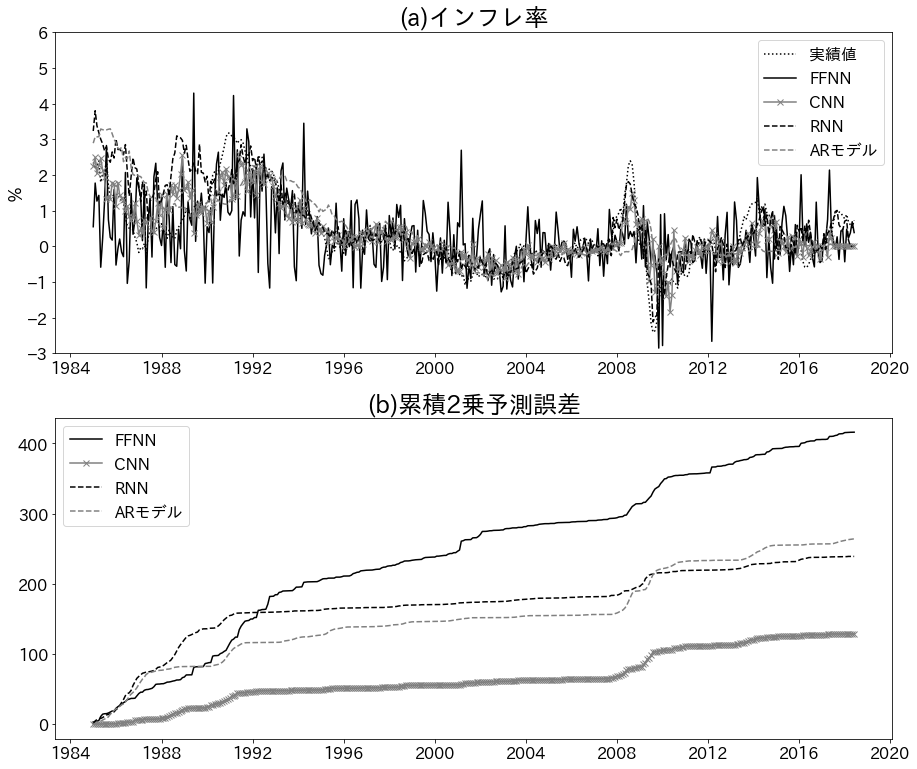

In [ ]:
#####
# グラフを描画
fig = plt.figure(figsize=(15, 13))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
ax1.set_title("(a)インフレ率", fontsize=24)
ax1.plot(dti[H + PERIOD :], np.ravel(msdata.x204[H + PERIOD :]), label="実績値", color="black", linestyle="dotted")
ax1.plot(dti[H + PERIOD :], np.ravel(predict_result9_list), label="FFNN", color="black")
ax1.plot(dti[H + PERIOD :], np.ravel(predict_result10_list), label="CNN", color="grey", marker="x")
ax1.plot(dti[H + PERIOD :], np.ravel(predict_result11_list), label="RNN", color='black', linestyle="dashed")
ax1.plot(dti[H + PERIOD :], np.ravel(predict_resultAR_list), label="ARモデル", color='grey', linestyle="dashed")
ax1.legend(loc="upper right", fontsize=16)
ax1.tick_params(labelsize=16)
ax1.set_ylim(-3, 6)
ax1.set_ylabel("％", fontsize=16)
ax2.set_title("(b)累積2乗予測誤差", fontsize=24)
ax2.plot(dti[H + PERIOD :], np.ravel(sqe_result9_list).cumsum(), label="FFNN", color="black")
ax2.plot(dti[H + PERIOD :], np.ravel(sqe_result10_list).cumsum(), label="CNN", color="grey", marker="x")
ax2.plot(dti[H + PERIOD :], np.ravel(sqe_result11_list).cumsum(), label="RNN", color='black', linestyle="dashed")
ax2.plot(dti[H + PERIOD :], np.ravel(sqe_resultAR_list).cumsum(), label="ARモデル", color='grey', linestyle="dashed")
ax2.legend(loc="upper left", fontsize=16)
ax2.tick_params(labelsize=16)

続いて、テキストデータを用いたマクロ経済予測の方法を紹介する。はじめに、内閣府の景気ウォッチャー調査のテキストデータをウェブスクレイピングによりダウンロードする。

In [ ]:
#####
# 内閣府・景気ウォッチャー調査のウェブスクレイピング
# カレントディレクトリの移動
os.chdir("/content/drive/My Drive/EWS")
# カレントディレクトリの取得
current_dir = os.getcwd()
# データの公表時点を読み込み（現在のホームページ）
date = pd.read_excel("/content/drive/My Drive/EWS/data_5.xlsx", sheet_name="hpdate_now", dtype=str)
for i in range(0, len(date), 1):
    year = date.year[i]
    month = date.month[i]
    day = date.day[i]
    timing = date.timing[i]
    url = "https://www5.cao.go.jp/keizai3/" + str(year) + "/" + str(month) + str(day) + "watcher/watcher4.csv"
    # Chromeを起動
    options = webdriver.ChromeOptions()
    options.add_argument('--headless')
    options.add_argument('--no-sandbox')
    options.add_argument('--disable-dev-shm-usage')
    driver = webdriver.Chrome('chromedriver',options=options)
    # ファイルをダウンロード
    driver.get(url)
    time.sleep(3)
    fn_before = "/content/drive/My Drive/EWS/watcher4.csv"
    fn_after = "/content/drive/My Drive/EWS/"+str(timing) + ".csv"
    os.rename(fn_before, fn_after)
    driver.quit()
    time.sleep(5)
# データの公表時点を読み込み（過去のホームページ）
date = pd.read_excel("/content/drive/My Drive/EWS/data_5.xlsx", sheet_name="hpdate_old", dtype=str)
for i in range(0, len(date), 1):
    heisei = date.heisei[i]
    month = date.month[i]
    timing = date.timing[i]
    url = "https://www5.cao.go.jp/keizai3/kako_csv/h" + str(heisei) + str(month) + "_watcher4.csv"
    # Chromeを起動
    options = webdriver.ChromeOptions()
    options.add_argument('--headless')
    options.add_argument('--no-sandbox')
    options.add_argument('--disable-dev-shm-usage')
    driver = webdriver.Chrome('chromedriver',options=options)
    # ファイルをダウンロード
    driver.get(url)
    time.sleep(3)
    fn_before = "/content/drive/My Drive/EWS/h" + str(heisei) + str(month) + "_watcher4.csv"
    fn_after = "/content/drive/My Drive/EWS/"+ str(timing) + ".csv"
    os.rename(fn_before, fn_after)
    driver.quit()
    time.sleep(5)

以下のコードにより、高村ほか(2006)の単語感情極性対応表を用いて、景気ウォッチャー調査の各月のコメントのセンチメント指数を計算し、回帰分析を行うと、図5.10を作成できる。なお、単語感情極性対応表は高村大也氏の[ホームページ](http://www.lr.pi.titech.ac.jp/~takamura/pubs/pn_ja.dic)からダウンロードすることができる。

In [ ]:
# プログラム5.16
# 日本語のみを抽出（記号、数字は削除）
nihongo = re.compile("[ぁ-んァ-ン一-龥]")


def clean(_list):
    new_list = []
    for item in _list:
        if nihongo.findall(item):
            new_list.append(item)
    return new_list


def vectorization_bow(df):
    vectorizer = CountVectorizer(token_pattern="(?u)\\b\\w+\\b", max_features=100000)
    vecs = vectorizer.fit_transform(df)
    header = vectorizer.get_feature_names()
    return vecs, header


# 単語感情極性対応表の読み込み
df_pn = pd.read_csv(
    "/content/drive/My Drive/pn_ja.dic", delimiter=":", encoding="cp932", names=["単語", "読み", "品詞", "感情値"]
)
df_pn = df_pn.groupby(["単語", "読み", "品詞"], as_index=False).first().reset_index(drop=True)
df_pn = df_pn.groupby(["単語"], as_index=False).first().reset_index(drop=True)

# 景気判断理由集の読み込み
files = sorted(glob.glob("*.csv"))
df_score = np.zeros([len(files), 1])
index = 0
for file in files:
    csvfile_open = open(file, encoding="cp932")
    csvfile_csvread = csv.reader(csvfile_open)
    text_list = []
    for i_csvfile_csvread in csvfile_csvread:
        temp_before = i_csvfile_csvread[5]
        temp_after = neologdn.normalize(temp_before)
        temp_clean = clean(temp_after)
        text_list.append(temp_clean)
    text_list = sum(text_list, [])
    text_whole = "".join(text_list)
    text_trim = re.sub(r"[回答が存在しない主だった回答等が存在しない追加説明及び具体的状況の説明]", "", text_whole)
    wakati = MeCab.Tagger("-Owakati")
    words = wakati.parse(text_trim).split()
    vecs, header = vectorization_bow(words)
    df_set = pd.DataFrame(vecs.toarray(), columns=header)
    df_tmp = pd.merge(
        pd.DataFrame(vecs.toarray(), columns=header).T.reset_index(),
        df_pn[["単語", "感情値"]],
        left_on="index",
        right_on="単語",
        how="left",
    ).dropna()
    df_word_count = (df_tmp.iloc[:, 2 : 2 + len(df_set)]).sum(axis=1)
    df_score[index] = sum(df_word_count * df_tmp["感情値"]) / sum(df_word_count)
    index = index + 1
rawdata = pd.read_excel("/content/drive/My Drive/data_5.xlsx", sheet_name="景気一致指数(内閣府)", header=[0])
model = linear_model.LinearRegression()
model.fit(df_score, rawdata.CI)
fitted = model.predict(df_score)
print(f"決定係数: {np.mean(model.score(df_score, rawdata.CI))}")

決定係数: 0.31043102513029097


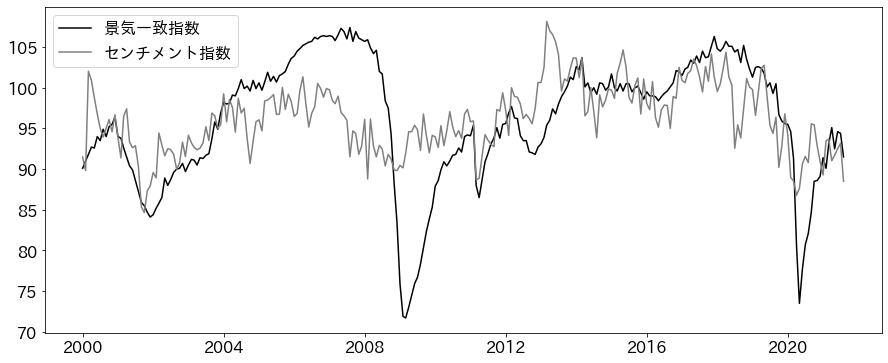

In [ ]:
#####
# グラフの描画
dti = pd.date_range("2000-01-01", periods=len(rawdata), freq="MS")
plt.plot(dti, rawdata.CI, label="景気一致指数", color="black")
plt.plot(dti, fitted, label="センチメント指数", color="grey")
plt.legend(loc="upper left", fontsize=16)
plt.tick_params(labelsize=16)

出現単語のBoW表現と機械学習手法を組み合わせたテキスト分析を行うと、図5.11を作成できる。

In [ ]:
# プログラム5.17
# ファイルの読み込み
files = sorted(glob.glob("*.csv"))
rawdata = pd.read_excel("/content/drive/My Drive/data_5.xlsx", sheet_name="景気一致指数(内閣府)", header=[0])
dlen = len(rawdata)
dti = pd.date_range("2000-01-01", periods=len(rawdata), freq="MS")


# BoWの計算
def calculation_bow(start, span):
    df_bow = pd.DataFrame()
    for i in range(start, span):
        file = files[i]
        time = file[-10:-4]
        csvfile_open = open(file, encoding="cp932")
        csvfile_csvread = csv.reader(csvfile_open)
        text_list = []
        for i_csvfile_csvread in csvfile_csvread:
            temp_before = i_csvfile_csvread[5]
            temp_after = neologdn.normalize(temp_before)
            temp_clean = clean(temp_after)
            text_list.append(temp_clean)
        text_list = sum(text_list, [])
        text_whole = "".join(text_list)
        text_trim = re.sub(r"[回答が存在しない主だった回答等が存在しない追加説明及び具体的状況の説明]", "", text_whole)
        # 形態素解析
        wakati = MeCab.Tagger("-Owakati")
        words = wakati.parse(text_trim).split()
        vecs, header = vectorization_bow(words)
        # 各時点における各単語の登場頻度を計算
        df_set = pd.DataFrame(vecs.toarray(), columns=header)
        df_bow_temp = df_set.sum()
        df_bow = pd.concat([df_bow, df_bow_temp], axis=1)
        df_bow = df_bow.rename(columns={0: time})
    df_bow = df_bow.fillna(0)
    counter = df_bow.sum(axis=1)
    df_bow = pd.concat([df_bow, counter], axis=1)
    df_bow = df_bow.rename(columns={0: "total"})
    df_sort = df_bow.sort_values("total", ascending=False)
    df_sort = df_sort.iloc[:, :-1].T
    return df_sort


# モデル推定
predict_result_list_en, sqe_result_list_en = [], []
predict_result_list_rf, sqe_result_list_rf = [], []
predict_result_list_lgbm, sqe_result_list_lgbm = [], []
predict_result_list_stk, sqe_result_list_stk = [], []
PERIOD = 60  # 訓練データのサンプルサイズ（60か月）
H = 0  # 予測期間（当月予測）
# スタッキングの1段目の関数
reg1 = linear_model.Lasso()
reg2 = linear_model.ElasticNet()
reg3 = svm.SVR()
reg4 = ensemble.BaggingRegressor()
reg5 = ensemble.RandomForestRegressor()
reg6 = lgb.LGBMRegressor()
# スタッキングの2段目の関数
meta_model = linear_model.Ridge()

predict_result_en = np.zeros((dlen - H) - PERIOD)
sqe_result_en = np.zeros((dlen - H) - PERIOD)
predict_result_rf = np.zeros((dlen - H) - PERIOD)
sqe_result_rf = np.zeros((dlen - H) - PERIOD)
predict_result_lgbm = np.zeros((dlen - H) - PERIOD)
sqe_result_lgbm = np.zeros((dlen - H) - PERIOD)
predict_result_stk = np.zeros((dlen - H) - PERIOD)
sqe_result_stk = np.zeros((dlen - H) - PERIOD)
for i in range((dlen - H) - PERIOD):
    # 訓練データの指定
    train_xx = calculation_bow(i, i + PERIOD + 1)
    train_y = rawdata.CI[i + H : i + H + PERIOD]
    scaler = StandardScaler()
    scaler.fit(train_xx)
    train_x_std = scaler.transform(train_xx)
    train_x = train_x_std[0 : PERIOD]
    # テストデータの指定
    test_x = train_x_std[PERIOD : PERIOD + 1]
    test_y = rawdata.CI[i + H + PERIOD : i + H + PERIOD + 1]
    # エラスティックネット
    model_en = linear_model.ElasticNetCV(cv=5, random_state=0)
    model_en.fit(train_x, train_y)
    forecast_en = model_en.predict(test_x)
    predict_result_en[i] = forecast_en
    sqe_en = ((test_y - forecast_en) ** 2).sum(axis=0)
    sqe_result_en[i] = sqe_en
    # ランダムフォレスト
    model_rf = ensemble.RandomForestRegressor(max_samples=0.5)
    model_rf.fit(train_x, train_y)
    forecast_rf = model_rf.predict(test_x)
    predict_result_rf[i] = forecast_rf
    sqe_rf = ((test_y - forecast_rf) ** 2).sum(axis=0)
    sqe_result_rf[i] = sqe_rf
    # ブースティング
    model_lgbm = lgb.LGBMRegressor(learning_rate=0.1)
    model_lgbm.fit(train_x, train_y)
    forecast_lgbm = model_lgbm.predict(test_x)
    predict_result_lgbm[i] = forecast_lgbm
    sqe_lgbm = ((test_y - forecast_lgbm) ** 2).sum(axis=0)
    sqe_result_lgbm[i] = sqe_lgbm
    # スタッキング
    model_stk = StackingCVRegressor(
        regressors=[reg1, reg2, reg3, reg4, reg5, reg6], meta_regressor=meta_model
    )
    model_stk.fit(train_x, train_y)
    forecast_stk = model_stk.predict(test_x)
    predict_result_stk[i] = forecast_stk
    sqe_stk = ((test_y - forecast_stk) ** 2).sum(axis=0)
    sqe_result_stk[i] = sqe_stk

predict_result_list_en.append(predict_result_en)
sqe_result_list_en.append(sqe_result_en)
predict_result_list_rf.append(predict_result_rf)
sqe_result_list_rf.append(sqe_result_rf)
predict_result_list_lgbm.append(predict_result_lgbm)
sqe_result_list_lgbm.append(sqe_result_lgbm)
predict_result_list_stk.append(predict_result_stk)
sqe_result_list_stk.append(sqe_result_stk)

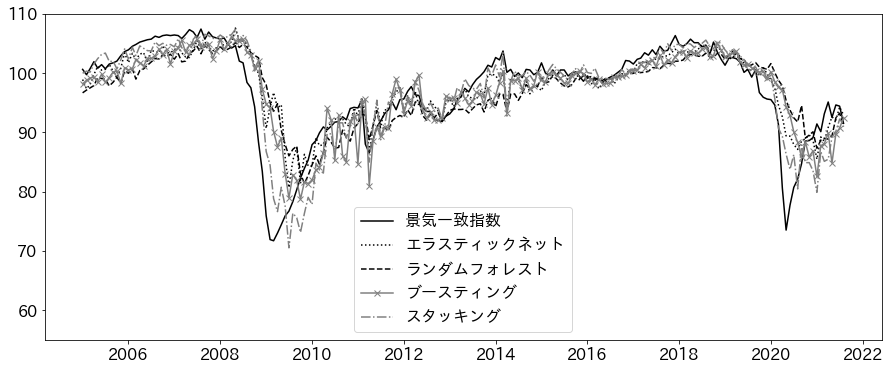

In [ ]:
#####
# グラフの描画
plt.plot(dti[H + PERIOD :], rawdata.CI[PERIOD:], label="景気一致指数", color="black")
plt.plot(dti[H + PERIOD :], np.ravel(predict_result_list_en), label="エラスティックネット", color="black", linestyle="dotted")
plt.plot(dti[H + PERIOD :], np.ravel(predict_result_list_rf), label="ランダムフォレスト", color="black", linestyle="dashed")
plt.plot(dti[H + PERIOD :], np.ravel(predict_result_list_lgbm), label="ブースティング", color="grey", marker="x")
plt.plot(dti[H + PERIOD :], np.ravel(predict_result_list_stk), label="スタッキング", color="grey", linestyle="dashdot")
plt.legend(loc="lower center", fontsize=16)
plt.ylim(55, 110)
plt.tick_params(labelsize=16)